In [1]:
from glob import glob
import pandas as pd
from Bio import SeqIO
import os
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
import dendropy
from dendropy.calculate import treemeasure
import numpy as np
import researchpy as rp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats


# name_map = {}
# for path in glob('/data/lucas/02-experiments/eLW009-agrobacterium_atlas/01-vir_analysis/weisberg_data/assemblies/Ti_Ri_plasmids/*.gbk'):
#     for file in SeqIO.parse(path, "gb"):
#         for f in file.features:
#             if (f.type == "source"):
#                 try:
#                     assert len(f.qualifiers['strain']) == 1
#                     name_map[ f.qualifiers['strain'][0] ] = path.split('/')[-1].replace('.gbk','').replace('_ti','').replace('_ri','')
#                 except:
#                     print(path, f)

# vir_db = pd.DataFrame(columns=['file','locus_tag','aa'])
# for path in glob('/data/lucas/02-experiments/eLW009-agrobacterium_atlas/01-vir_analysis/weisberg_data/assemblies/Ti_Ri_plasmids/*.gbk'):
#     for file in SeqIO.parse(path, "gb"):
#         id_aa = {}
#         for f in file.features:
#             if (f.type == "CDS"):
#                 try:
#                     assert len(f.qualifiers['locus_tag']) == 1 and len(f.qualifiers['translation']) == 1
#                     id_aa[ f.qualifiers['locus_tag'][0] ] = f.qualifiers['translation'][0]
#                 except:
#                     continue
#         tmp_df = pd.DataFrame([id_aa]).T.reset_index()
#         tmp_df.columns = ['locus_tag','aa']
#     tmp_df['file'] = path.split('/')[-1].replace('.gbk','')
#     vir_db = pd.concat([vir_db, tmp_df]).reset_index(drop=True)

# ============================================

def output(df,outfile,name_col, concat=False):
    if concat:
        with open(f'output/{outfile}.faa','w') as file:
            for _,row in df.drop_duplicates(subset=["name_"+name_col]).iterrows():
                    file.write(f'>{row["name_"+name_col]}\n{row[f"{outfile}_concat"]}\n')
    else:
         with open(f'output/{outfile}.faa','w') as file:
            for _,row in df.drop_duplicates(subset=['name']).iterrows():
                    file.write(f'>{row["name"]}\n{row["aa"]}\n')
    
    os.system(f'mafft --quiet output/{outfile}.faa > output/{outfile}.aln')
    os.system(f'FastTree -quiet output/{outfile}.aln > output/{outfile}.tree')

df = pd.DataFrame(columns=["name","aa","handle"])
for fasta_file in glob('vir_genes/*.faa'):
    fasta_handle = fasta_file.split('/')[-1].replace('.faa','')
    fasta_sequences = SeqIO.parse(open(fasta_file),'fasta')

    name_seqs = {}
    for fasta in fasta_sequences:
        name_seqs[fasta.id] = str(fasta.seq)
    tmp_df = pd.DataFrame([name_seqs]).T.reset_index()
    tmp_df.columns = ["name","aa"]
    tmp_df['handle'] = fasta_handle

    df = pd.concat([df,tmp_df]).reset_index(drop=True)
    del tmp_df

df['ID'] = df['name'].apply(lambda x: x.split('_')[0])

# virB
virB_df = df[df['handle'].apply(lambda x: 'virB' in x)].copy()

for i in range(1,9):
    if i == 1:
        curr_df = virB_df.query(f'handle == "virB{i}"').copy()
    else:
        curr_df = tmp_df.copy()

    tmp_df = curr_df.merge(
        virB_df.query(f'handle == "virB{i+1}"').copy(),
        on='ID',
        suffixes=[f'_virB{i}',f'_virB{i+1}']
    )
virB_df = tmp_df.rename(columns={'handle':'handle_virB9','aa':'aa_virB9'})
aa_cols = sorted([col for col in virB_df.columns if 'aa' in col])
virB_df['virB_concat'] = virB_df[aa_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
# output(virB_df, 'virB', 'virB1', concat=True)

# virB4
virB4 = df[df['handle'] == 'virB4'].copy()
# output(virB4, 'virB4', None, concat=False)

# virC12
virC_df = df[df['handle'].apply(lambda x: 'virC' in x)].copy()
virC1 = virC_df.query('handle == "virC1"').copy()
virC2 = virC_df.query('handle == "virC2"').copy()

virC_df = virC1.merge(
        virC2,
        on='ID',
        suffixes=[f'_virC1',f'_virC2']
    )

aa_cols = sorted([col for col in virC_df.columns if 'aa' in col])
virC_df['virC12_concat'] = virC_df[aa_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
# output(virC_df, 'virC12', 'virC1', concat=True)

# virD12
virD_df = df[df['handle'].apply(lambda x: 'virD' in x)].copy()
virD1 = virD_df.query('handle == "virD1"').copy()
virD2 = virD_df.query('handle == "virD2"').copy()

virD12 = virD1.merge(
        virD2,
        on='ID',
        suffixes=[f'_virD1',f'_virD2']
    )

aa_cols = sorted([col for col in virD12.columns if 'aa' in col])
virD12['virD12_concat'] = virD12[aa_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
# output(virD12, 'virD12', 'virD1', concat=True)

# virD4
virD4 = virD_df.query('handle == "virD4"').copy()
# output(virD4, 'virD4', None, concat=False)

# virD5
virD5 = virD_df.query('handle == "virD5"').copy()
# output(virD5, 'virD5', None, concat=False)

# virE12
virE_df = df[df['handle'].apply(lambda x: 'virE' in x)].copy()
virE1 = virE_df.query('handle == "virE1"').copy()
virE2 = virE_df.query('handle == "virE2"').copy()

virE12 = virE1.merge(
        virE2,
        on='ID',
        suffixes=[f'_virE1',f'_virE2']
    )

aa_cols = sorted([col for col in virE12.columns if 'aa' in col])
virE12['virE12_concat'] = virE12[aa_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
# output(virE12, 'virE12', 'virE1', concat=True)

# virE3
virE3 = virE_df.query('handle == "virE3"').copy()
# output(virE3, 'virE3', None, concat=False)

# virH1
virH1 = df.query('handle == "virH1"').copy()
output(virH1, 'virH1', None, concat=False)

# virH2
virH2 = df.query('handle == "virH2"').copy()
# output(virH2, 'virH2', None, concat=False)

# virF
virF = df.query('handle == "virF"').copy()
# output(virF, 'virF', None, concat=False)

In [6]:
import dendropy
dendropy.__version__

'4.6.1'

In [2]:
dist_df = pd.DataFrame(columns=['tax1','tax2','dist','cluster'])
for tree_file in glob("output/*.tree"):
    handle = tree_file.split('/')[-1].replace('.tree','')
    print(handle)

    dists=[]
    tree = dendropy.Tree.get_from_path(tree_file, "newick")
    for x in tree.taxon_namespace:
        if 'pTiC58' in x.label:
            for y in tree.taxon_namespace:
                dists.append([x.label,y.label,
                            treemeasure.patristic_distance(tree,x,y)])
    tmp_df = pd.DataFrame(dists,columns=['tax1','tax2','dist'])
    tmp_df['cluster'] = handle
    dist_df = pd.concat([dist_df,tmp_df]).reset_index(drop=True)
    del tmp_df
dist_df = dist_df.query('cluster != "virB"').copy()



virD5
virF
virE3
virE12
virD12
virC12
virH1
virB4
virD4
virH2
virB


In [3]:
# recreate mitch's virD data
name_map = {'A4':"A4 066",
'Ach5':"pTiACH5",
'B21':"B21 90",
'C58':"pTiC58",
'NCIB':"NCIB 8196", 
# 'Q15':, 
'pRi':"pRi1724", 
'S4':"pTiS4",
# 'T60', 
# 'TiAB', 
'TiBo':"pTiBo542"}
inv_name_map = {v: k for k, v in name_map.items()}


In [4]:
idx = []
matches = []
for i,row in dist_df.iterrows():
    for val in name_map.values():
        if val in row['tax2']:
            idx.append(i)
            matches.append(val)
filtered_dist_df = dist_df[dist_df.index.isin(idx)].copy()
filtered_dist_df['match'] = matches

In [5]:
def plot(filename, cluster,sheet='data'):
    df = pd.read_excel(filename,sheet_name=sheet)
    df['GFP_log'] = df.GFP.apply(np.log2)
    dfsum = rp.summary_cont(df['GFP'].groupby(df['Strain']))

    c58dist_df = filtered_dist_df.query(f'cluster == "{cluster}"').copy()
    c58dist_df['Strain'] = c58dist_df['match'].replace(inv_name_map)
    if any(c58dist_df['match'].duplicated()):
        print(f'{cluster} contains duplicate matches')

    df_dist_compare = dfsum.merge(c58dist_df,on='Strain')
    df_dist_compare['log2gfp'] = np.log2(df_dist_compare.Mean)
    df_dist_compare['cluster'] = cluster

    return df_dist_compare
    # f, ax = plt.subplots(figsize=(5,3))
    # plt.scatter(df_dist_compare.dist,df_dist_compare.Mean,linewidths=1,edgecolors='black',color='lightskyblue')
    # sns.despine(top=True)
    # # plt.xlabel('Phylogenetic Distance From C58 Allele')
    # # plt.ylabel('GFP',size=12)
    # pearson = scipy.stats.pearsonr(df_dist_compare.dist,df_dist_compare.Mean)
    # spearman = scipy.stats.spearmanr(df_dist_compare.dist,df_dist_compare.Mean)
    # plt.title(f'${cluster}$ (pearson = {pearson.pvalue:.2f}, spearman = {spearman.pvalue:.2f})')
    # plt.savefig(f'{cluster}.png',dpi=600,transparent=True)


df_dist_compare = pd.concat([plot('vir_allele_data/2022.7.25 virD allele.xlsx','virD12'),
           plot('vir_allele_data/2023.1.9 virH2 allele virH12 comp.xlsx','virH2'),
           plot('vir_allele_data/2022.9.5 virC12 alleles.xlsx','virC12'),
           plot('vir_allele_data/2023.2.6 virB allele.xlsx','virB4'),
           plot('vir_allele_data/2022.10.17 vird4 allle.xlsx','virD4'),
           plot('vir_allele_data/2022.11.7 virD5 virE3 alleles.xlsx','virD5',sheet='virD5_data'),
           plot('vir_allele_data/2022.11.7 virD5 virE3 alleles.xlsx','virE3',sheet='virE3_data'),
           plot('vir_allele_data/2022.9.12 virE12 allele.xlsx','virE12'),
           plot('vir_allele_data/2022.12.5 virF virH1.xlsx','virF',sheet='dataF'),
           plot('vir_allele_data/2022.12.5 virF virH1.xlsx','virH1',sheet='dataH1')
           ]).reset_index(drop=True)



virD12 contains duplicate matches




virC12 contains duplicate matches


virB4 contains duplicate matches


virD4 contains duplicate matches








virF contains duplicate matches




In [6]:
df_dist_compare.to_pickle('df_dist_compare.pkl')

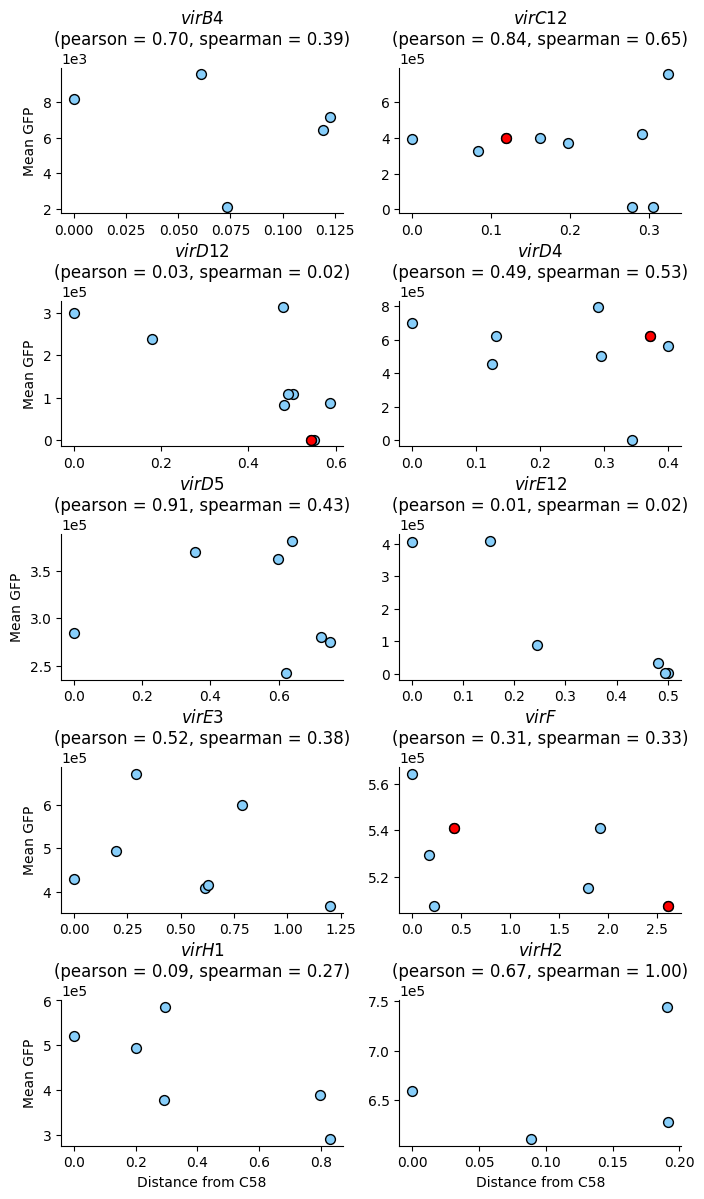

In [7]:
import matplotlib.gridspec as gridspec
import cv2 as cv

fig = plt.figure(figsize = (8,14))
gs = gridspec.GridSpec(5,2,hspace=0.6)

clusters = sorted(df_dist_compare['cluster'].unique())
for i, g in enumerate(gs):
    ax = fig.add_subplot(g)
    query = df_dist_compare.query(f'cluster == "{clusters[i]}"')
    duplicated = query[query['match'].duplicated()]
    g = sns.scatterplot(data=query,x='dist',y='Mean',linewidth=1,edgecolor='black',color='lightskyblue',ax=ax,s=50)
    g = sns.scatterplot(data=duplicated,x='dist',y='Mean',linewidth=1,edgecolor='black',color='red',ax=ax,s=50)
    pearson = scipy.stats.pearsonr(query.dist,query.Mean)
    spearman = scipy.stats.spearmanr(query.dist,query.Mean)
    g.set(xlabel=None,ylabel=None,title=f'${clusters[i]}$\n(pearson = {pearson.pvalue:.2f}, spearman = {spearman.pvalue:.2f})')
    ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
    sns.despine()
    if i in [8,9]:
        g.set(xlabel='Distance from C58')
    if i % 2 == 0:
        g.set(ylabel='Mean GFP')

fig.savefig('tmp.png',dpi=600,facecolor='white',bbox_inches='tight')